# Цель
Изучить статистические характеристики метода измерения уровня сигнала. Нужно узнать как меняется уровень сигнала с различных сканеров когда все элементы системы (окружение, сканеры и браслет) находятся в неизменном состоянии.

Понимание статистик позволит понять какое количество сигналов с каждого сканера нужно получить, чтобы  вычислить среднее значение с высокой точность. Также это позволит понять насколько высокая точность необходима, чтобы различать сигнал от конкретного сканера при нахождении браслета в разных помещениях. Знаниче этих характеристик позволит спроектировать наиболее эффективный алгоритм определения положения браслета, который будет брать во внимание полученные характеристики.

Таким образом, в рамках этого исследование необходимо:
1.  Собрать сигналы от браслета в разных положениях в каждой комнате. В каждой комнате положения должны выбираться так, чтобы получить наиболее различные сигналы. По 100 сигналов с каждого сканера в каждом положении браслета. При этом в помещении не должно быть движущихся людей и котов, чтобы собрать максимально чистые данные.
2. Для каждого положения вычислить среднее и дисперсию для каждого сканера.
3. Посмотреть как меняется дисперсия в зависимости от среднего значения (насколько дисперсия увеличивается/уменьшается в зависимости от среднего значения уровня сигнала).
4. Посмотреть как среднее по каждому сканеру меняется в зависимости от помещения. Найти минимальную разницу между средними фиксированного сканера из разных помещений. Посмотреть на распределение разниц между положениями из разных помещений.
5. Посчитать какое количество сигналов нужно, чтобы с высокой вероятностью (p=0.05) уловить разницу между средними из двух положений из разных близких комнат.
6. Подобрать параметры фильтра Калмана, которые максимально быстро приближали бы среднее к значению, позволяющему различить два положения из близкикх комнат.

In [2]:
from server import config
from datetime import datetime
from asyncio_mqtt import Client, MqttError
from contextlib import AsyncExitStack
from sklearn.cluster import MeanShift
import pandas as pd
import numpy as np
import seaborn as sbs
from matplotlib import pyplot as plt
import jsons
from server.kalman import KalmanRSSI

## Сбор данных

In [3]:
async def collect_signals(room):
    new_signals = {}
    position = str(datetime.utcnow().timestamp())
    async with Client(
        hostname=config.MQTT_BROKER_URL, port=config.MQTT_BROKER_PORT,
        username=config.MQTT_USERNAME, password=config.MQTT_PASSWORD) as client:
        async with client.unfiltered_messages() as messages:
            await client.subscribe("room_presence/#")
            async for message in messages:
                event = jsons.loads(message.payload.decode())
                if event['id'] != 'eb:cd:02:7f:98:91'.upper():
                    continue

                scanner = message.topic.split('/')[1]
                scanner_signals = new_signals.get(scanner, [])
                scanner_signals.append({'rssi': event['rssi'], 'when': datetime.utcnow()})
                new_signals[scanner] = scanner_signals

                print(dict([(k, len(new_signals[k])) for k in new_signals.keys()]))

                if sum(len(new_signals[k]) >= 100 for k in new_signals.keys()) >= 2:
                    return [
                        {'scanner': s, 'rssi': v['rssi'], 'when': v['when'], 'position': '{}-{}'.format(str(room), str(position)), 'room': room} 
                        for s, values in new_signals.items() for v in values
                    ]

async def collect_and_save_signals(room):
    new_signals = await collect_signals(room)
    df = pd.read_csv('./signals.csv')
    df = pd.concat([df, pd.DataFrame(new_signals)])
    df.to_csv('./signals.csv', index=False)

In [4]:
# await collect_and_save_signals('bedroom')

Во время сбора данных не удалось соблюсти чистоту стерильной комнаты – мимо ходили люди, коты, в некоторых положениях устройство могло сместиться на несколько сантиметров. Для каждого положения сбор данных заканчивался когда количество сигналов с двух сканеров достигало 100 по каждому.

__Предположение__: 100 значений на сканер должно дать приемлемую точность вычисленного среднего сигнала. Нужно в этом убедиться путем анализа распределения в разных положениях, также нужно проверить какой _p_ дает такой объем выборки и какой нужен минимальный объем выборки для приемлемого _p_ чтобы сократить время сбора данных, в каждом положении приходилось ждать от 10 до 20 минут, чтобы собрать 100 сигналов по двум сканерам, это много

## Изучаем статистики

In [5]:
data_df = pd.read_csv('./signals.csv')
data_df['when'] = data_df['when'].astype('datetime64')
room_df = data_df[data_df['room'] == 'office'].copy()

<AxesSubplot:xlabel='scanner', ylabel='rssi'>

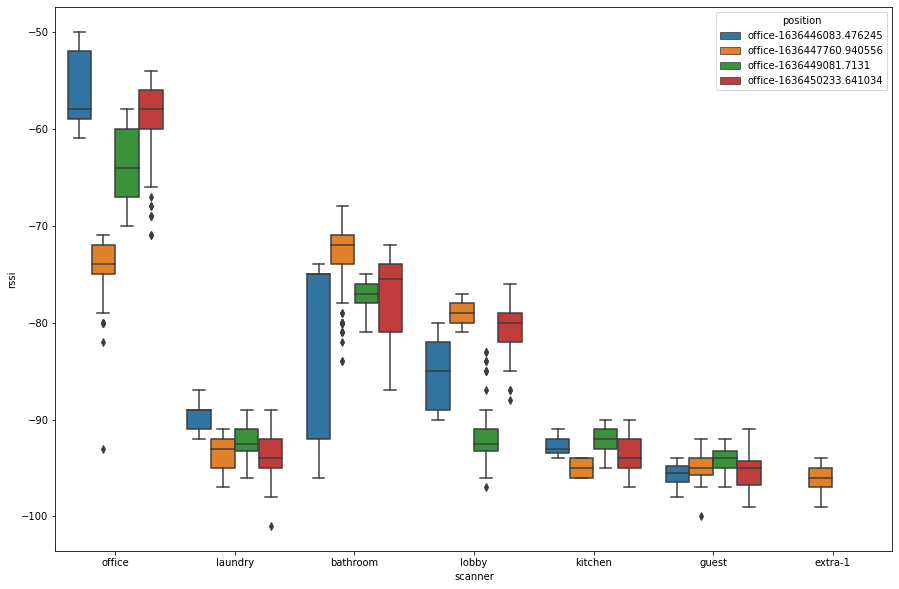

In [6]:
f = plt.figure(figsize=(15, 10))
ax = f.add_subplot(111)
sbs.boxplot(data=room_df, x='scanner', y='rssi', hue='position', ax=ax)

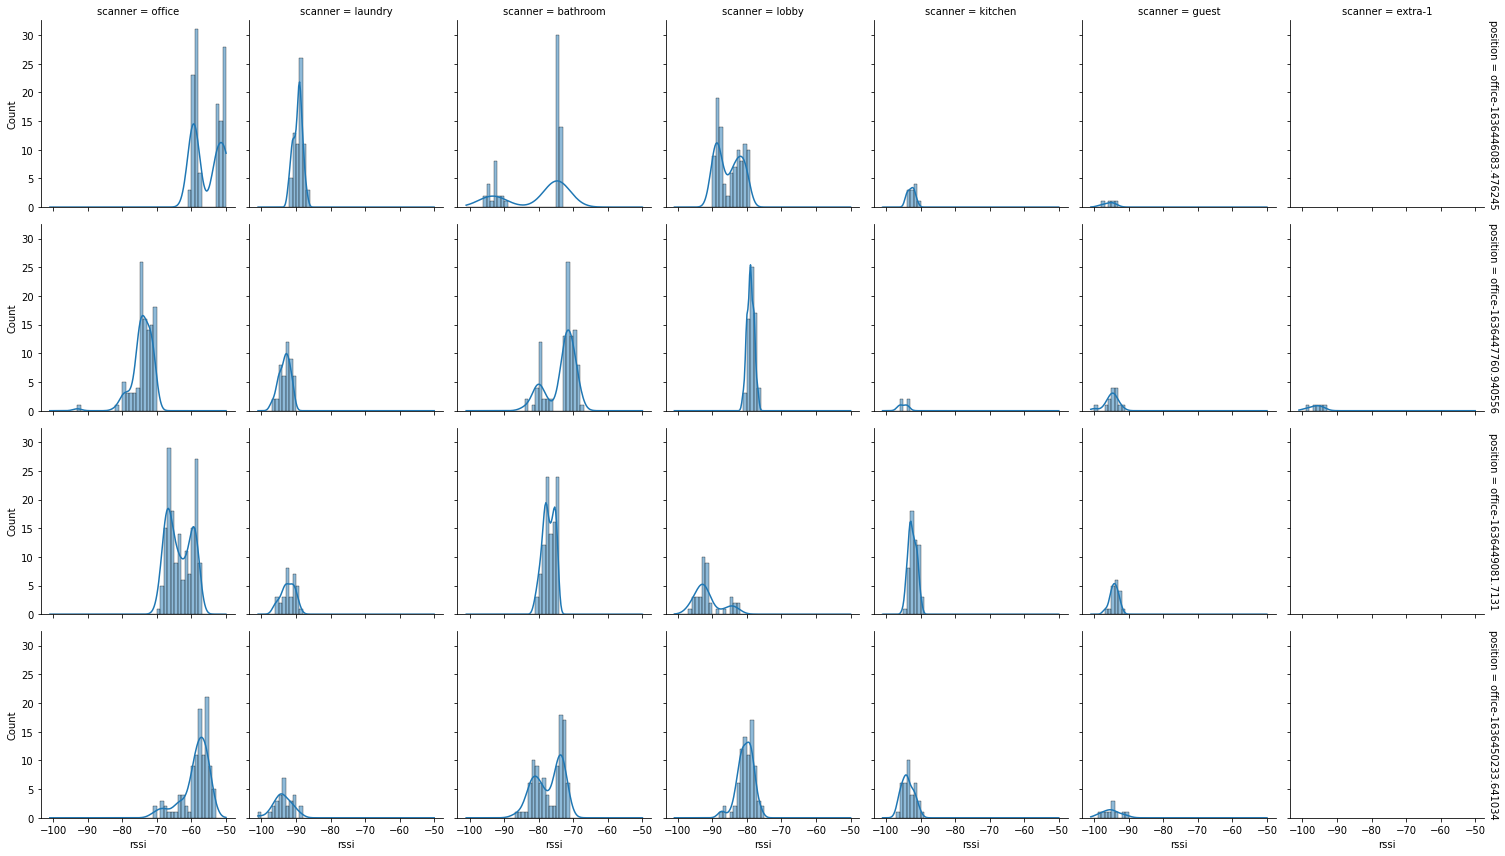

In [7]:
sbs.displot(
    room_df, x="rssi", col="scanner", row="position",
    binwidth=1, height=3, facet_kws=dict(margin_titles=True),
    kind='hist', kde=True,
)

Заметим, что в одном положении сигнал с одного сканера может иметь несколько пиков. Это может говорить о том, что среда каким-то образом изменилась и количество помех увеличилось/уменьшилось, что привело к изменению уровня получаемого со сканера среднего сигнала.

Получим все пики для кадого положения устройства во всех помещениях. Найденные значения - возможные (полученные во время сбора данных) средние  уровня сигнала для каждого помещения.

__Предположение:__ отфильтрованные Калманом значения будут колебаться в приделах этих средних для каждого сканера-помещения.

In [8]:
results_df = []

def get_center_size(data_df, x):
    x = np.round(x)
    return len(data_df[(data_df['rssi'] >= x - 1) & (data_df['rssi'] <= x + 1)])

for room in data_df['room'].unique():
    for scanner in data_df['scanner'].unique():
        for position in data_df['position'].unique():
            curr_data = data_df[(data_df['scanner'] == scanner) & (data_df['position'] == position) & (data_df['room'] == room)]
            X = list(zip(curr_data['rssi'], [1] * len(curr_data['rssi'])))
            if len(X) > 0:
                ms = MeanShift(bandwidth=2).fit(X)
                new_centers = sorted([{
                    'scanner': scanner,
                    'room': room,
                    'position': position,
                    'rssi_center': np.round(x[0]),
                    'size': get_center_size(curr_data, x[0]),
                    'cluster_idx': i,
                } for i, x in enumerate(ms.cluster_centers_)], key=lambda x: -x['size'])

                # Дополнительно отфильтруем низкие пики. Нас не интересуют пики,
                # значение которого вместе с +-1 окрестностью встречалось меньше X раз
                if new_centers[0]['size'] >= 30:
                    results_df += [x for x in new_centers if x['size'] >= 30]
                else:
                    results_df += [new_centers[0]]

results_df = pd.DataFrame(results_df)

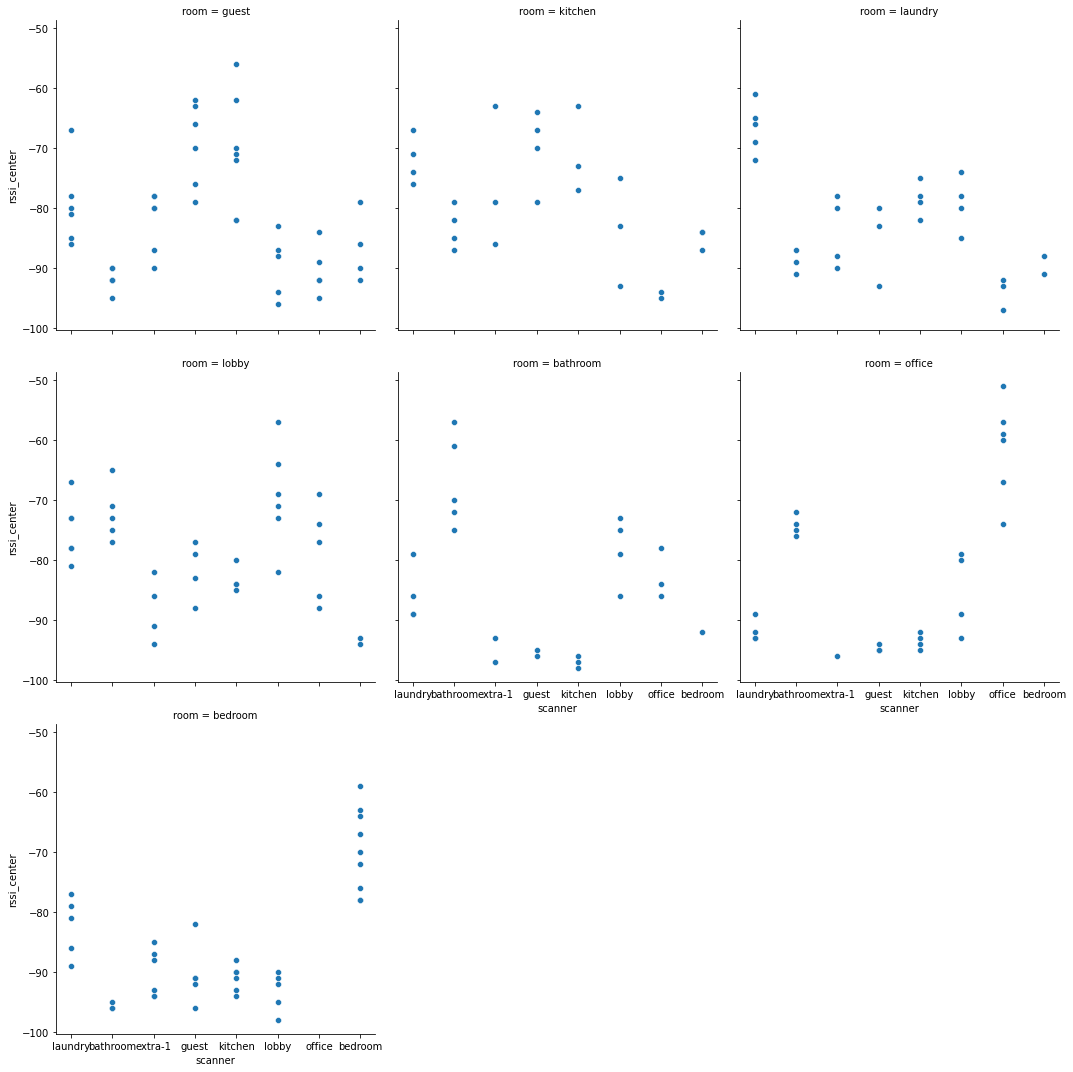

In [9]:
sbs.relplot(data=results_df, x='scanner', y='rssi_center', col='room', kind="scatter", col_wrap=3)

<AxesSubplot:xlabel='scanner', ylabel='rssi_center'>

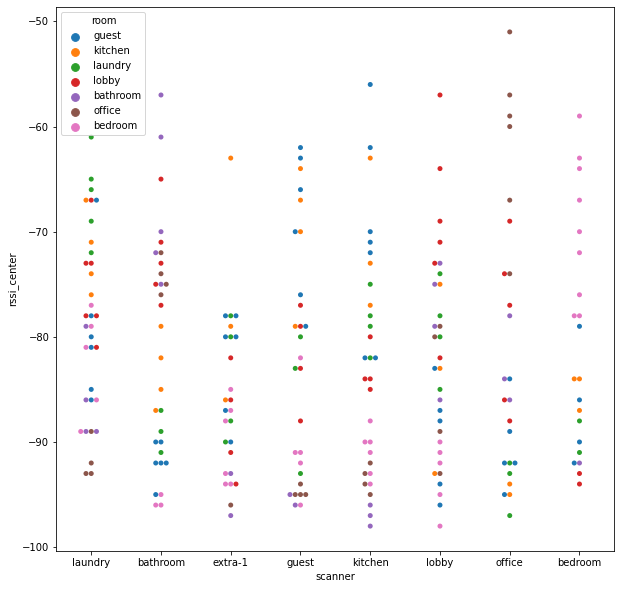

In [10]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
sbs.swarmplot(data=results_df, x='scanner', y='rssi_center', hue='room', ax=ax)

Из данных графиков видно, что для каждого помещения прослеживается свой уникальный паттерн. При этом паттерны пересекаются. Из этого следует, что искомый алгоритм классификации должен определять положение устройства в каждом помещении отдельно, чтобы иметь возможность одновременно позиционировать устройство в нескольких помещениящ, ввиду того, что могут быть пересечения (устройство можно отнести более чем к одному помещению, если сравнивать с имеющимися данными).

__Предположение:__ для фиксированного сканера и фиксированного положения устройства найденные средние уровни сигналов определяют разброс возможных значений. Таким образом искомый алгоритм классификации должен быть обучен в том числе на промежуточных значениях между минимумом и максимумом, так алгоритм получится более генерализованным.

# Наивный алгоритм
Исходя из сделанных выше предположений есть идея наивного алгоритма: имея интервалы возможных значений сигнала для каждого сканера в каждом помещении, найти те интервалы, в которые попадают текущие значения со сканеров. Отсортировать помещения по убыванию количества совпадений с интервалами. Взять помещения со 100% совпадением и считать их включенными. Если таковых нет – считать включенными первые два помещения по количеству совпадений. Если совпадений нет вовсе – считать все помещения выключенными. 

Реализуем этот алгоритм и изучим метрики качества. Нам больше всего нехочется иметь ложно отрицательные результаты (человек в помещении и свет выключился), ложно положительные значения тоже хотелось бы свести к разумному минимум

In [32]:
singal_ranges_df = results_df.groupby(['room', 'scanner']).agg(min=('rssi_center', 'min'), max=('rssi_center', 'max'))
sorted_scanners = sorted(results_df['scanner'].unique())
sorted_rooms = sorted(results_df['room'].unique())

In [74]:
def naive_predict_presence(X):
    signals_df = pd.DataFrame({
        'room':  [rr for r in sorted_rooms for rr in ([r] * len(sorted_scanners))],
        'scanner': sorted_scanners * len(sorted_rooms), 
        'rssi': X * len(sorted_rooms)
    }).set_index(['room', 'scanner'])
    local_ranges_df = singal_ranges_df.copy()
    local_ranges_df['min'] += -2
    local_ranges_df['max'] += 2
    local_ranges_df['min_diff'] = local_ranges_df['min'] - signals_df['rssi']
    local_ranges_df['max_diff'] = local_ranges_df['max'] - signals_df['rssi']
    local_ranges_df['in_range'] = False
    local_ranges_df.loc[(local_ranges_df['min_diff'] <= 0) & (local_ranges_df['max_diff'] >= 0), 'in_range'] = True
    local_ranges_df['abs_min_diff'] = local_ranges_df[['min_diff', 'max_diff']].abs().min(axis=1)
    local_ranges_df.loc[(local_ranges_df['in_range'] == True), 'abs_min_diff'] = 0
    rooms_perf_df = local_ranges_df.groupby(['room']).agg(error_sum=('abs_min_diff', 'sum')).sort_values('error_sum')

    if sum(local_ranges_df['in_range'] == True) == 0:
        return []
    if rooms_perf_df.iloc[0]['error_sum'] == 0:
        return list(rooms_perf_df[rooms_perf_df['error_sum'] == 0].index)

    return list(rooms_perf_df.iloc[0:2].index)

naive_predict_presence([-100]*len(sorted_scanners))

['bedroom', 'office']

### Генерация правдоподобных данных
Чтобы измерять качество алгоритма нужны данные, на которых будет производиться измерение. Чем ближе данные будут к реальным тем лучше. Данные, собранные выше, нельзя назвать естественным и близкими к реальности, так как браслет лежал по 20 минут неподвижно. Эти данные больше подходят для анализа статистических характеристик метода измерения. Но из них можно попробовать построить более реалистичные данные эмитирую перемещение браслета из позиции в позицию, из комнаты в комнату.

In [99]:
session_dur_df = data_df.groupby(['room', 'position']).agg(when_min=('when', 'min'), when_max=('when', 'max'), signals=('when', 'count'))
session_dur_df['when_diff'] = np.round((session_dur_df['when_max'] - session_dur_df['when_min']) / np.timedelta64(1, 's'))
session_dur_df['frequency'] = session_dur_df['signals'] / session_dur_df['when_diff']
signals_per_sec = session_dur_df['frequency'].mean()
print('In average received {} signals per second'.format(signals_per_sec))

In average received 0.5945392712977545 signals per second


In [104]:
def generate_data(circles=10):
    filters = dict([(s, KalmanRSSI(R=10, Q=0.15)) for s in sorted_scanners])
    X = []
    for i in range(circles):
        for room in np.random.choice(sorted_rooms, len(sorted_rooms), replace=False):
            for position in np.random.choice(data_df[data_df['room'] == room]['position'].unique(), replace=False):
                print(position)

generate_data(1)

guest-1636381230.660919
guest-1636382193.409617
guest-1636385040.689816
guest-1636385793.542457
guest-1636389973.804161
office-1636446083.476245
office-1636447760.940556
office-1636449081.7131
office-1636450233.641034
lobby-1636398557.066242
lobby-1636399374.493363
lobby-1636432665.500383
lobby-1636433560.346345
laundry-1636395142.845797
laundry-1636396515.363262
laundry-1636397595.691643
kitchen-1636391808.493248
kitchen-1636392941.816702
kitchen-1636394018.697996
bathroom-1636400347.580892
bathroom-1636401442.261931
bathroom-1636432147.233132
bedroom-1636450960.314251
bedroom-1636454036.645166
bedroom-1636455301.521138
bedroom-1636456912.828853
bedroom-1636460257.085355


## Оптимальный объем выборки
Сбор 100 сигналов на 2 сканера в одном положении занимал от 10 до 20 минут. Хочется сократить это время и понять какой минимум времени нужно ждать, чтобы получить те же средние значения что и в полной выборке. Это можно сделать аналитически и численно. Аналитически путем анализа распределения и задания доверительных интервалов для некоторой точности. Численно путем оптимизации некоторой функции потерь, которая будет равна 1 при 10 сигналах со сканера и в точности совпадающему среднему с средним по всей доступной выборке, равна 0 если объем выборки равен всей доступной выборке.

## Поведение Калмана

In [ ]:
room_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1765 entries, 4550 to 6314
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   scanner   1765 non-null   object        
 1   rssi      1765 non-null   int64         
 2   when      1765 non-null   datetime64[ns]
 3   position  1765 non-null   object        
 4   room      1765 non-null   object        
dtypes: datetime64[ns](1), int64(1), object(3)
memory usage: 147.3+ KB
